In [1]:
from data_generator import PriceLoader, get_sp500_tickers
from BenchmarkStrategy import BenchmarkStrategy
from MovingAverageStrategy import MovingAverageStrategy
from RSIStrategy import RSIStrategy
from MACDStrategy import MACDStrategy
from VolatilityBreakoutStrategy import VolatilityBreakoutStrategy

import os
import glob
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt


In [2]:
#getting all tickers already stored in parquet files, will randomly choose 25
DATA_DIR = "sp500_prices"

files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".parquet")]
assert files, f"No .parquet files found in '{DATA_DIR}'"

tickers = [os.path.splitext(f)[0] for f in files]

# Picking a ticker at random with a set seed for reproducibility
random.seed(42)
ticker = random.choice(tickers)
print("Sample ticker:", ticker)

Sample ticker: NXPI


In [3]:
pl = PriceLoader([ticker], data_dir=DATA_DIR)
df = pl.load(ticker)


assert 'AdjClose' in df.columns, df.columns

df = df[['AdjClose']].sort_index().copy()
df['date'] = df.index
df.head()

,AdjClose,date
Date,,
2010-08-06,12.496696,2010-08-06
2010-08-09,12.496696,2010-08-09
2010-08-10,12.139647,2010-08-10
2010-08-11,11.380920,2010-08-11
2010-08-12,11.059572,2010-08-12


In [4]:
BENCHMARK_X = 10   # how many shares to buy on day 1 for the benchmark
INITIAL_CASH = 1_000_000.0

frames = {
    'Benchmark': BenchmarkStrategy(df[['AdjClose','date']].copy()).generate_signals(BENCHMARK_X),
    'MA_20_50':  MovingAverageStrategy(df[['AdjClose','date']].copy()).generate_signals(),
    'VolBreak':  VolatilityBreakoutStrategy(df[['AdjClose','date']].copy()).generate_signals(),
    'MACD':      MACDStrategy(df[['AdjClose','date']].copy()).generate_signals(),
    'RSI_14':    RSIStrategy(df[['AdjClose','date']].copy()).generate_signals(),
}
list(frames.keys())

['Benchmark', 'MA_20_50', 'VolBreak', 'MACD', 'RSI_14']

In [5]:
def backtest_one_ticker(signals_df, initial_cash=INITIAL_CASH):
    d = signals_df.sort_values('date').copy()
    cash = float(initial_cash)
    holds = 0
    rec = []

    for _, r in d.iterrows():
        price = float(r['AdjClose'])
        sig   = int(r['signal'])  # your strategies emit 0/1 (benchmark emits x only first day)
        if sig > 0 and cash >= price:
            # assignment rule: 1 share per buy signal (the benchmark's big first signal will buy 1 here too)
            cash -= price
            holds += 1
        total_value = cash + holds * price
        rec.append((r['date'], cash, holds, total_value))

    out = pd.DataFrame(rec, columns=['date','cash','holdings','total_value'])
    out['pnl'] = out['total_value'] - out['total_value'].iloc[0]
    return out

perf = {name: backtest_one_ticker(sig_df) for name, sig_df in frames.items()}
{ k: v.shape for k, v in perf.items() }

{'Benchmark': (3625, 5),
 'MA_20_50': (3624, 5),
 'VolBreak': (3605, 5),
 'MACD': (3624, 5),
 'RSI_14': (3612, 5)}

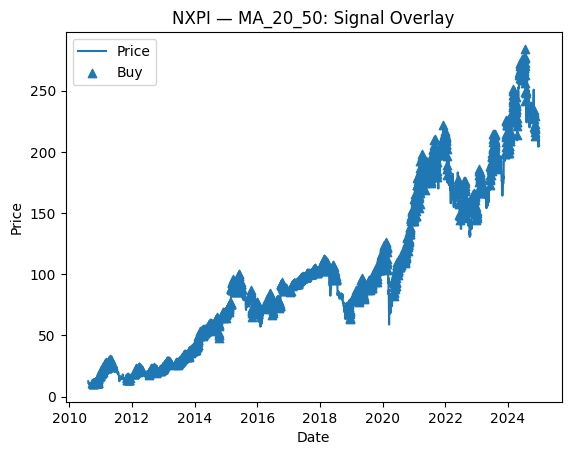

In [6]:
STRAT = 'MA_20_50'   # try: 'Benchmark', 'VolBreak', 'MACD', 'RSI_14'
sig_df = frames[STRAT].sort_values('date')

fig = plt.figure()
ax = fig.gca()
ax.plot(sig_df['date'], sig_df['AdjClose'], label='Price')
buy_mask = sig_df['signal'] > 0   # already shifted to act on prior day inside your files
ax.scatter(sig_df.loc[buy_mask, 'date'], sig_df.loc[buy_mask, 'AdjClose'], marker='^', label='Buy')
ax.set_title(f'{ticker} — {STRAT}: Signal Overlay')
ax.set_xlabel('Date'); ax.set_ylabel('Price'); ax.legend()
plt.show()

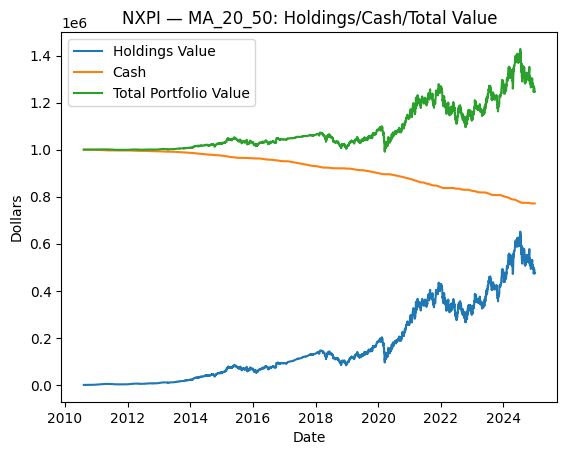

In [7]:
out = perf[STRAT]

fig = plt.figure()
ax = fig.gca()
ax.plot(out['date'], out['holdings'] * sig_df['AdjClose'].values, label='Holdings Value')
ax.plot(out['date'], out['cash'], label='Cash')
ax.plot(out['date'], out['total_value'], label='Total Portfolio Value')
ax.set_title(f'{ticker} — {STRAT}: Holdings/Cash/Total Value')
ax.set_xlabel('Date'); ax.set_ylabel('Dollars'); ax.legend()
plt.show()

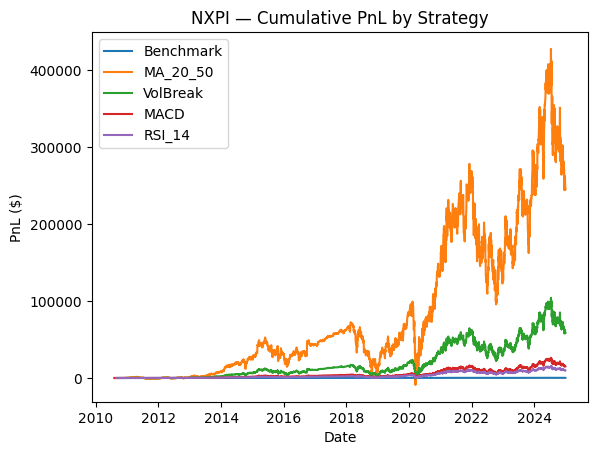

In [8]:
fig = plt.figure()
ax = fig.gca()
for name, out in perf.items():
    ax.plot(out['date'], out['pnl'], label=name)
ax.set_title(f'{ticker} — Cumulative PnL by Strategy')
ax.set_xlabel('Date'); ax.set_ylabel('PnL ($)'); ax.legend()
plt.show()

In [10]:
def summarize(df):
    tv = df['total_value']
    ret = float(tv.iloc[-1] - tv.iloc[0])
    dd = ((tv / tv.cummax()) - 1).min() * 100.0
    r = tv.pct_change().dropna()
    sharpe = float(r.mean()/r.std()*np.sqrt(252)) if len(r)>1 and r.std()>0 else np.nan
    return {'Total Return ($)': ret, 'Max Drawdown (%)': dd, 'Sharpe (≈, daily)': sharpe}

pd.DataFrame({k: summarize(v) for k,v in perf.items()}).T

,Total Return ($),Max Drawdown (%),"Sharpe (≈, daily)"
Benchmark,192.431206,-0.009127,0.298813
MA_20_50,245670.100675,-14.303946,0.250271
VolBreak,58302.309126,-4.193178,0.210898
MACD,14948.061173,-1.112947,0.203726
RSI_14,9847.047900,-0.618579,0.236930
